#  꼭 구글 코렙 환경에서 해주세요
pydub 라이브러리 오류가있습니다.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydub

In [3]:
from pydub import AudioSegment
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
your_path = '/content/drive/MyDrive/240620-LR' # 240620-LR 폴더 파일 경로를 지정해주세요

# 전처리

In [5]:
# 이동평균필터
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# 정규화 함수
def min_max_normalize(data):
    data = np.array(data)
    data[data == -np.inf] = -100  # -inf를 -100으로 변환 오류때문에,,
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# 무음구간 찾는 함수. 이 함수엔 정규화와 이동평균필터가 적용된 값들이 들어가야한다.
def detect_silence_intervals(smoothed_times, modified_smoothed_dB_values):
    silence_intervals = [] # 무음구간 기록용
    start = None
    for i, value in enumerate(modified_smoothed_dB_values):
        # 0인 구간을 찾음
        if value == 0 and start is None:
            start = smoothed_times[i]
        # 그렇지 않다면,
        elif value != 0 and start is not None:
            end = smoothed_times[i] # 끝이라고 판단.
            silence_intervals.append((start, end))
            start = None # 다시 start를 none이라 판단
        # 반복

    #마지막으로 start가 none이 아니면 마지막 구간을 end로 취급
    if start is not None:
        silence_intervals.append((start, smoothed_times[-1]))

    return silence_intervals

# 오디오에 대해 원하는 단위로 분할하는 역할
def make_chunks(audio_segment, chunk_length_ms):
    chunks = [audio_segment[i:i + chunk_length_ms] for i in range(0, len(audio_segment), chunk_length_ms)]
    return chunks

def make_graph(audio_path, vector,chunk_length_ms=10, max_time_s=10, smooth_window_size=50):
    audio = AudioSegment.from_file(audio_path) # 오디오 파일 가져오기
    chunks = make_chunks(audio, chunk_length_ms) # 미리세컨드 단위로 끊기

    dB_values = [chunk.dBFS for chunk in chunks] # 청크의 데시벨
    times = np.arange(len(dB_values)) * (chunk_length_ms / 1000.0) # 시간

    # max_time_s까지 데이터를 자르기
    max_chunks = max_time_s * 1000 // chunk_length_ms
    dB_values = dB_values[:max_chunks]
    times = times[:max_chunks]

    # 정규화
    normalized_dB_values = min_max_normalize(dB_values)

    # 이동 평균 적용
    smoothed_dB_values = moving_average(normalized_dB_values, smooth_window_size)
    smoothed_times = times[:len(smoothed_dB_values)]

    # smoothed_dB_values에서 0.5 미만 값을 0으로 설정
    threshold = 0.5
    modified_smoothed_dB_values = np.where(smoothed_dB_values < threshold, 0, smoothed_dB_values)


    silence_intervals = detect_silence_intervals(smoothed_times, modified_smoothed_dB_values)
    # 묵음 시작과 끝을 뺴서 그 시간만큼 vector에 더함.
    for start, end in silence_intervals:
        duration = end - start
        vector.append(f'{duration:.2f}')
    return vector




# 노인 훈련 데이터 준비


In [7]:
train_OB = []
for i in range(1,10):
  try:
    audio_path = f'{your_path}/train/OB/{i}.mp3'
    vector_train_OB = []
    vector_train_OB= list(map(float, make_graph(audio_path,vector_train_OB, chunk_length_ms=10, max_time_s=300, smooth_window_size=50)))
    train_OB += vector_train_OB
    print(vector_train_OB)
  except:
    print('다음파일로 넘어갑니다.')

[2.04, 1.9, 1.97, 1.59, 2.24, 0.35, 1.61, 2.28, 1.77, 0.91, 1.23, 1.21, 2.62, 2.37, 1.04, 0.21, 0.53, 1.36, 1.48, 0.35, 1.68, 0.91, 0.71, 1.72, 0.51, 0.17, 1.09, 1.65, 0.57, 1.99, 2.93, 0.62, 1.0, 0.85, 2.73, 0.16, 1.11, 1.28, 1.34, 0.83, 0.99, 1.97, 1.65, 0.53, 1.52, 0.92, 0.64, 1.64, 1.09, 1.7, 1.51, 0.54, 0.56, 1.2, 1.05, 0.8, 1.08, 1.43, 1.23, 0.76, 0.82, 2.59, 0.99, 0.48, 1.29, 1.33, 0.83, 1.44, 1.63, 1.11, 1.44]
[1.61, 0.23, 1.36, 0.72, 1.3, 1.22, 1.39, 2.11, 1.93, 1.02, 1.62, 1.21, 1.77, 0.29, 1.73, 0.81, 1.16, 0.96, 0.91, 0.31, 1.03, 0.28, 1.03, 0.26, 0.23, 2.25, 1.48, 1.51, 0.75, 1.2, 0.94, 0.33, 2.74, 0.59, 1.28, 1.36, 0.19, 0.39, 1.76, 0.87, 2.21, 1.59, 1.5, 0.7, 1.06, 1.7, 1.29, 1.63, 1.53, 1.58, 1.44, 0.56, 0.76, 0.25, 2.3, 0.37, 1.57, 1.13, 1.04, 1.39, 1.2, 1.78, 1.2, 1.34, 1.23, 0.89, 1.52, 1.17, 1.32, 1.91]
[0.6, 0.26, 1.36, 2.04, 2.38, 1.23, 1.47, 1.08, 0.84, 0.53, 1.19, 1.33, 1.48, 1.2, 0.36, 0.98, 2.08, 0.88, 0.97, 0.37, 0.39, 1.74, 0.57, 1.42, 2.2, 2.38, 1.45, 0.88,

# 청년 훈련 데이터 준비

In [8]:
train_YB = []
for i in range(1,7):
  try:
    audio_path = f'{your_path}/train/YB/{i}.mp3'
    vector_train_YB = []
    vector_train_YB= list(map(float, make_graph(audio_path,vector_train_YB, chunk_length_ms=10, max_time_s=300, smooth_window_size=50)))
    train_YB += vector_train_YB
    print(vector_train_YB)
  except:
    print('다음파일로 넘어갑니다.')

[0.32, 0.45, 0.39, 0.39, 0.43, 0.43, 0.36, 0.17, 0.95, 0.32, 0.37, 0.4, 0.29, 0.31, 0.26, 0.02, 0.35, 0.4, 0.54, 0.34, 0.44, 0.36, 0.32, 0.27, 0.36, 0.36, 0.42, 0.28, 0.17, 0.32, 0.05, 0.24, 0.26, 0.4, 0.19, 0.35, 0.36, 0.39, 0.45, 0.38, 0.32, 0.52, 0.16, 0.48, 0.32, 0.25, 0.35, 0.18, 0.1, 0.35, 0.38, 0.37, 0.11, 0.28, 0.34, 0.18, 0.09, 0.66, 0.39, 0.37, 0.47, 0.04, 0.34, 0.25, 0.45, 0.13, 0.19, 0.55, 0.46, 0.31, 0.28, 0.11, 0.06, 0.44, 0.45, 0.31, 0.45, 0.44, 0.43, 0.4, 0.44, 0.39, 0.42, 0.14, 0.39, 0.41, 0.71, 0.49, 0.22, 0.34, 0.23, 0.17, 0.44, 0.34, 0.35, 0.38, 0.11, 0.41, 0.19, 0.54, 0.24, 0.5, 0.6, 0.09, 0.1, 0.44, 0.26, 0.42, 0.05, 0.34, 0.48, 0.5, 0.39, 0.29, 0.41, 0.55, 0.23, 0.28, 0.54, 0.05, 0.49, 0.22, 0.25, 0.05, 0.34, 0.29, 0.07, 0.63, 0.61, 0.43]
[0.55, 0.14, 0.03, 0.69, 0.33, 0.1, 0.43, 0.2, 0.35, 0.05, 0.05, 0.34, 0.56, 0.33, 0.38, 0.56, 0.44, 0.41, 0.32, 0.14, 0.4, 0.49, 0.35, 0.54, 0.24, 0.44, 0.47, 0.33, 0.4, 0.38, 0.47, 0.46, 0.24, 0.32, 0.53, 0.39, 0.54, 0.29, 0.3

# 테스트 데이터 준비

In [9]:
test_OB = []
for i in range(1,6):
  try:
    audio_path = f'{your_path}/test/{i}.mp3'
    vector_test_OB = []
    vector_test_OB= list(map(float, make_graph(audio_path,vector_test_OB, chunk_length_ms=10, max_time_s=300, smooth_window_size=50)))
    test_OB += vector_test_OB
    print(vector_test_OB)
  except:
    print('다음파일로 넘어갑니다.')

[2.15, 0.36, 0.97, 2.04, 1.24, 2.29, 0.29, 0.17, 1.11, 0.1, 0.07, 1.4, 1.57, 1.53, 0.31, 0.54, 0.4, 0.62, 0.07, 0.38, 1.01, 0.07, 0.09, 0.94, 0.42, 1.04, 0.47, 0.77, 1.72, 1.68, 0.03, 0.93, 0.22, 0.39, 0.89, 2.08, 1.74, 1.23, 1.66, 0.31, 0.59, 0.46, 0.71, 1.29, 0.34, 1.2, 1.05, 0.42, 0.05, 0.93, 0.33, 1.72, 0.59, 0.41, 0.34, 1.4, 0.3, 3.43, 0.3, 0.46, 2.55, 1.45, 1.61, 0.45, 0.43, 2.69, 1.04, 1.28, 0.82, 0.86, 1.52, 1.48, 0.39, 1.41, 3.74, 0.76, 0.25, 0.06, 0.05, 0.98, 2.4, 1.22, 4.02, 0.78, 2.18, 1.59, 3.34, 0.86, 0.3, 0.24, 0.42, 1.51, 0.56, 0.18, 0.22, 1.47, 1.19, 0.82, 1.03, 2.28, 1.79, 2.11, 2.43, 0.89]
[0.54, 0.34, 0.04, 1.14, 1.61, 0.63, 0.97, 1.26, 1.32, 2.7, 1.41, 0.32, 0.85, 0.96, 0.79, 0.35, 0.07, 0.31, 0.88, 0.38, 1.38, 1.18, 0.37, 2.52, 1.42, 0.57, 0.78, 2.86, 1.74, 3.02, 0.92, 2.93, 2.56, 1.16, 0.05, 0.8, 1.63, 1.43, 2.19, 1.48, 1.3, 1.06, 0.43, 1.49, 0.88, 1.37, 0.74, 1.05, 0.77, 1.71, 1.48, 0.53, 1.48, 0.72, 0.47, 1.18, 1.16, 1.06, 0.1, 0.05, 0.05, 2.57, 2.64, 2.24, 2.4

# 모델 선언

In [10]:
import numpy as np

class eLDA:
    def __init__(self, x, learning_rate, n_iterations):
        self.x = x # 데이터 x
        self.learning_rate = learning_rate # 학습률
        self.n_iterations = n_iterations # 학습의 반복 수
        self.w = np.array([0.999]*len(self.x)) # 가중치 w

    # 지수분포의 람다값을 계산하는 함수
    def lambda_(self):
        new_x = self.x * self.w # 가중치를 곱한 새로운 x값
        mean = np.average(new_x) # 새로운 x의 평균
        lambda_ = 1 / mean # 람다는 새로운 x의 평균의 역수
        return lambda_


    # log likelihood 계산 함수
    def log_likelihood(self, w):
        new_x = self.x * w # 가중치를 곱한 새로운 x값
        mean = np.average(new_x) # 새로운 x의 평균
        lambda_ = 1 / mean # 람다는 새로운 x의 평균의 역수
        log_likelihood = np.sum(np.log(lambda_) - lambda_ * new_x) # log likelihood 계산
        return log_likelihood

    # 중앙 차분법으로 기울기 계산 함수
    def gradient(self, w):
        epsilon = 1e-5  # 미분을 위한 작은 값
        grad = np.zeros_like(w) # w와 동일한 크기의 0벡터 생성
        for i in range(len(w)):
            w_plus = np.array(w) # w 생성
            w_plus[i] += epsilon # w에 미분을 위한 작은 값을 더함
            loss_plus = self.log_likelihood(w_plus) # 그 값을 log likelihood 함수에 대입

            w_minus = np.array(w) # w 생성
            w_minus[i] -= epsilon # w에 미분을 위한 작은 값을 뺌
            loss_minus = self.log_likelihood(w_minus) # 그 값을 log likelihood 함수에 대입

            grad[i] = (loss_plus - loss_minus) / (2 * epsilon) # 두 값의 평균이 중앙차분법의 결과
        return grad

    # 경사 상승법 함수
    def gradient_ascent(self):

        for i in range(0, self.n_iterations+1): # iteration만큼 반복

            before_log_likelihood = self.log_likelihood(self.w) # 최적화 전 log likelihood 값

            grad = self.gradient(self.w) # w에 대한 미분값

            self.w = self.w + self.learning_rate * grad # 경사 상승법

            self.w = np.clip(self.w, 0.001, 0.999)  # 0과 1 사이로 제한

            after_log_likelihood = self.log_likelihood(self.w) # 최적화 전 log likelihood 값

            if np.abs(after_log_likelihood - before_log_likelihood) <= 1e-3: # log likelihood의 변화량이 0.001이하라면 학습을 중단한다
              print(f'training stopped at {i+1} iteration') # 몇 번째 iteration에서 중단되는지 print
              break

        print('training finished') # 중단이 되지 않고 학습이 완료되면 print

    # 데이터 x에 대한 지수분포 확률값 계산 함수
    def exponential_distribution(self, x):
        new_x = self.x * self.w # 가중치를 곱한 새로운 x값
        mean = np.average(new_x) # 새로운 x의 평균
        lambda_ = 1 / mean # 람다는 새로운 x의 평균의 역수
        px = lambda_ * np.exp(-lambda_ * x) # 지수분포의 확률값 계산
        return px

# 선형판별식 계산 함수
def get_linear_discriminant(OB, YB, x):
    a = x*(YB.lambda_() - OB.lambda_()) + np.log(OB.lambda_() / YB.lambda_()) + np.log( len(OB.x) / len(YB.x) ) # 보고서에 식 유도과정이 있습니다.
    return a

# 시그모이드 계산 함수
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

learning_rate = 0.001 # 학습률
n_iterations = 100 # 반복 학습수

# 학습 진행

In [11]:
x_OB = np.array(train_OB[:500]) # 노인 데이터 500개 준비

OB = eLDA(x_OB, learning_rate, n_iterations) # 노인 class 설정

OB.gradient_ascent() # 노인 데이터 학습 진행

training finished


In [12]:
x_YB = np.array(train_YB[:500]) # 청년 데이터 500개 준비

YB = eLDA(x_YB, learning_rate, n_iterations) # 청년 class 설정

YB.gradient_ascent() # 청년 데이터 학습 진행

training finished


# prediciton

In [13]:
x_test = np.array(test_OB) # 노인 테스트 데이터 100개 준비

linear_discriminant = get_linear_discriminant(OB, YB, x_test) # 테스트 데이터의 선형판별식 계산

sigmoid_res = (sigmoid(linear_discriminant)) # 테스트 데이터의 시그모이드 값 계산

print(f'테스트 데이터가 노인일 확률(평균) : {np.mean(sigmoid_res)*100}%')

테스트 데이터가 노인일 확률(평균) : 65.97667744082429%


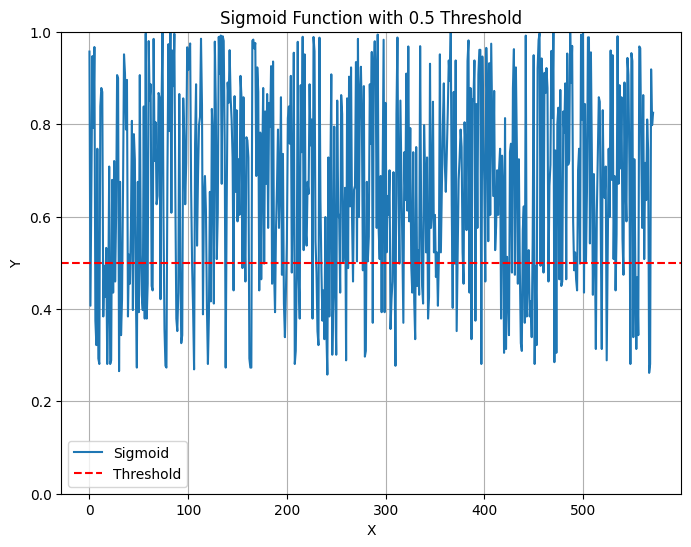

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 위에서 구한 테스트 데이터의 시그모이드 값(테스트 데이터가 노인 클래스에 속할 확률)을 시각화 합니다.

x = sigmoid_res
plt.figure(figsize=(8, 6))
plt.plot(range(len(x)), x, label='Sigmoid')
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sigmoid Function with 0.5 Threshold')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()


# sequence마다 기존 LDA와 비교

In [15]:
cnt = 0

for a in sigmoid_res:
    if a >= 0.5: # 시그 모이드 값이 0.5이상이면 노인 클래스로 판별
        cnt += 1
print(f'eLDA의 정확도 : {cnt / len(x_test)*100}%')

eLDA의 정확도 : 70.1048951048951%


In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.concatenate((x_OB, x_YB), axis=0) # 기존 LDA의 train data
y = np.concatenate((np.zeros(len(x_OB)), np.ones(len(x_YB))), axis=0) # 기존 LDA의 label data

lda = LinearDiscriminantAnalysis() # 기존 LDA 선언
lda.fit(X.reshape(-1, 1), y.reshape(-1)) # 기존 LDA 학습

new_data = x_test.reshape(-1, 1) # 테스트 데이터
prediction = lda.predict(new_data) # 기존 LDA가 테스트 데이터에 대해 예측 실행

cnt = 0

for i, pred in enumerate(prediction):
  if pred == 0: # 예측값이 0이라면 노인 클래스로 판별
    cnt += 1
print(f'기존 LDA의 정확도 : {cnt / len(x_test)*100}%')

기존 LDA의 정확도 : 57.51748251748252%
